<a href="https://colab.research.google.com/github/ELVAN13091999/my-first-binder/blob/main/Lands%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Land use Classification¶
Personal Project By Elvan Vensiando

Special thanks to IBM Corporation and MIT for providing free online courses in cognitiveclass.ai

Special thanks to https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery/metadata under CC0:Public Domain license for providing dataset publicly.

-> We will use libraries os and glob to work with files and folders. We will also use Matplotlib and Seaborn for visualizing our dataset to gain a better understanding of the images we are going to be handling. NumPy will be used for arrays of images. Scikit-Learn - for classical classification models. Pandas - for DataSet creation.

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import json
from PIL import Image
from colormap import rgb2hex, hex2rgb

#Classifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import plot_confusion_matrix

Loading of Data
For convenience, let's create a function that downloads all and displays the last images of land and masks from a specified directory. All training pictures and their masks have to be placed in differend directories. Separate a csv file that contains the description of land use classes.

The function has to work in the following way:

1. Download a csv file json.load() and display classes description.
2. Download all images from a specific directory:
Image.open(). 
3. Display the last image + mask. 
4. Form and return a DataSet that has to be an array of tuples [image, mask].

Remark: the downloaded directories contain 72 images and their masks located in different subfolders according to image resolutions. Due to the fact that the dataset for training will represent each point in the form of a separate record - the size of the dataset will be too large to conduct the training on a local computer. Therefore, we will select a separate folder that contains 9 photos and their masks.

In [15]:
def get_data(folder, file):
    # download json
    f = open(folder + "/" + file,)
    data = json.load(f)
    f.close()
    cl = {}
    # Create a dictionary with classes
    for i, c in enumerate(data['classes']):
        cl[i] = dict(c)
        
    for k, v in cl.items():
        print('Class', k)
        for k2, v2 in v.items():
            print("   ", k2, v2)
    data = []
    
    # download images
    sd = [item for item in os.listdir(folder) if os.path.isdir(folder + '/' + item)] # a list of subdirectories
    print("Subdirectories: ", sd)
    for f in sd[1:2]: #choose one of the subdirectories to download
        print("Downloading: ", f)
        images = glob(folder + "/" + f + "/images" + "/*.jpg") # create a list of image files
        for im in images:
            mask_f = im.replace("images", "masks").replace("jpg", "png") # create a list of mask files
            image = Image.open(im) 
            mask = Image.open(mask_f)
            if len(np.array(mask).shape) > 2:
                data.append([image, mask])
        fig = plt.figure(figsize = (10,10)) #display the last image + mask
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.show()

    return (data)

In [20]:
!unzip -o -q archive.zip #unzipping

Class 0
    title Water
    shape polygon
    color #50E3C2
    geometry_config {}
Class 1
    title Land (unpaved area)
    shape polygon
    color #F5A623
    geometry_config {}
Class 2
    title Road
    shape polygon
    color #DE597F
    geometry_config {}
Class 3
    title Building
    shape polygon
    color #D0021B
    geometry_config {}
Class 4
    title Vegetation
    shape polygon
    color #417505
    geometry_config {}
Class 5
    title Unlabeled
    shape polygon
    color #9B9B9B
    geometry_config {}
Subdirectories:  ['.ipynb_checkpoints', 'Tile 6', 'Tile 2', 'Tile 1', 'Tile 8', 'Tile 7', 'Tile 5', 'Tile 3', 'Tile 4']
Downloading:  Tile 6


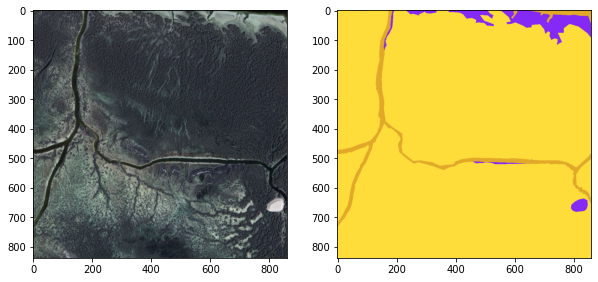

In [21]:
d = "Semantic segmentation dataset"
f = "classes.json"
data = get_data(d, f)

As you can see, the csv file contains a description of 6 land use classes. Each class has its own color in the mask file. We downloaded all the pictures and their masks from a separate directory and formed a set of data lists consisting of tuples of picture-mask.

-> Let's see how many images we downloaded:

In [22]:
len(data)

9

As we can see, we dowloaded 9 images. Let's use first 4 images and masks for training and last 5 - for tests.

Let's make a function that will create a DataSet.

Each image is a set of points. Each point is represented by a tuple of RGB (red, green, blue). Every color is a number [0-1) for float or [0, 255) for int. Therefore, every image is a 3D array (height, width, color). Or a 2D array for gray scale.

To establish the dependence of color -> land use class, we need to convert each image into a dataset of the form (r, g, b) -> class.

To do this, we need to transform the image into a color matrix np.asarray(), and then transform it into a one-dimensional form np.flatten(). To construct the output field, we need to additionally convert the color tuple (r, g, b) from the mask file into hex format: rgb2hex().

In [23]:
def create_DataSet(data):
    DS = pd.DataFrame()
    for image, mask in data:
        # transform image to matrix
        im = np.asarray(image) 
        mk = np.asarray(mask)
        # transform a one-dimension array of r, g, b colors
        red = im[:,:,0].flatten()
        green = im[:,:,1].flatten()
        blue = im[:,:,2].flatten()
        im_f = np.array([red, green, blue])
        red = mk[:,:,0].flatten()
        green = mk[:,:,1].flatten()
        blue = mk[:,:,2].flatten()
        # calculate hex classes
        h = np.array([rgb2hex(*m) for m in zip(red, green, blue)])
        mk_f = np.array([red, green, blue, h])      
        d = np.concatenate((im_f, mk_f), axis=0)
        # create a DataSet
        DS_new = pd.DataFrame(np.transpose(d), columns = ['Im_Red', 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue', 'HEX'])
        if len(DS) == 0:
            DS = DS_new
        else:
            DS = DS.append(DS_new)
    return DS

-> Let's print out training dataset and test dataset

In [25]:
print("Create a training DataSet")
train = create_DataSet(data[:4])
print(train)
print("Create a test DataSet")
test = create_DataSet(data[4:])
print(test)

Create a training DataSet
       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0          25       38      21    226      169      41  #E2A929
1          23       36      19    226      169      41  #E2A929
2          20       33      16    226      169      41  #E2A929
3          21       34      17    226      169      41  #E2A929
4          23       36      19    226      169      41  #E2A929
...       ...      ...     ...    ...      ...     ...      ...
719837    127      139     135    132       41     246  #8429F6
719838    125      137     133    132       41     246  #8429F6
719839    120      132     128    132       41     246  #8429F6
719840    121      133     129    132       41     246  #8429F6
719841    123      135     131    132       41     246  #8429F6

[2879368 rows x 7 columns]
Create a test DataSet
       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0         156      144     146    110      193     228  #6EC1E4
1         129      117     1

-> Let's study the column types of training and test DataSets.

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2879368 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 175.7+ MB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599210 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 219.7+ MB


As you can see, all the columns have object type.

The last column 'HEX' contains colors in hex format. Therefore, it is necessary to change the type of this data to categorical.

In [28]:
train.loc[:, 'HEX'] = train['HEX'].astype('category')
train['HEX']

0         #E2A929
1         #E2A929
2         #E2A929
3         #E2A929
4         #E2A929
           ...   
719837    #8429F6
719838    #8429F6
719839    #8429F6
719840    #8429F6
719841    #8429F6
Name: HEX, Length: 2879368, dtype: category
Categories (5, object): ['#000000', '#8429F6', '#9B9B9B', '#E2A929', '#FEDD3A']

In [29]:
test.loc[:, 'HEX'] = test['HEX'].astype('category')
test['HEX']

0         #6EC1E4
1         #6EC1E4
2         #6EC1E4
3         #6EC1E4
4         #6EC1E4
           ...   
719837    #FEDD3A
719838    #FEDD3A
719839    #FEDD3A
719840    #FEDD3A
719841    #FEDD3A
Name: HEX, Length: 3599210, dtype: category
Categories (7, object): ['#000000', '#3C1098', '#6EC1E4', '#8429F6', '#9B9B9B', '#E2A929', '#FEDD3A']

-> All other columns contain colors in int format, therefore we should change their types:

In [30]:
cl = ['Im_Red', 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue']
train[cl] = train[cl].astype('int64')
test[cl] = test[cl].astype('int64')
print (train.info())
print (test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2879368 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Im_Red    int64   
 1   Im_Green  int64   
 2   Im_Blue   int64   
 3   Mk_Red    int64   
 4   Mk_Green  int64   
 5   Mk_Blue   int64   
 6   HEX       category
dtypes: category(1), int64(6)
memory usage: 156.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599210 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Im_Red    int64   
 1   Im_Green  int64   
 2   Im_Blue   int64   
 3   Mk_Red    int64   
 4   Mk_Green  int64   
 5   Mk_Blue   int64   
 6   HEX       category
dtypes: category(1), int64(6)
memory usage: 195.7 MB
None


-> Let’s visualize our data and see what exactly we are working with. We use seaborn to plot the number of pixel classes and you can see what the output looks like.

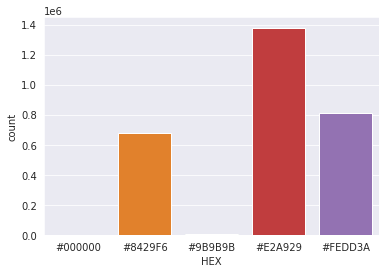

In [31]:
c = pd.DataFrame(train['HEX'])
sns.set_style('darkgrid')
sns.countplot(x="HEX", data=c)

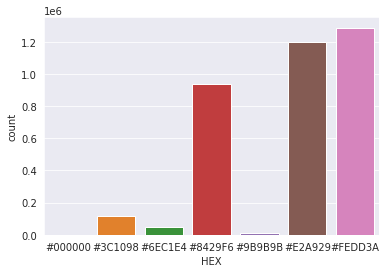

In [32]:
c = pd.DataFrame(test['HEX'])
sns.set_style('darkgrid')
sns.countplot(x="HEX", data=c)

The training and test DataSets contain similar distribution of images classes.

We will use sklearn.linear_model.LogisticRegression() classifier for mask analysis. It is a very fast and simple classifier. In the next lab we will compare different classifiers.

We will use first 3 columns (RGB of image pixel) as imput parameters, and the last column (HEX color of mask picture) as an output.

The fit() and score() functions are used for training and evaluating the accuracy.

We will use function plot_confusion_matrix() for analysis.

In [33]:
clf = LogisticRegression(max_iter=100, n_jobs=-1)
c = train.columns
clf.fit(train[c[0:3]], train[c[-1:]].values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy train DataSet:  91.1% Accuracy test DataSet:  77.2%


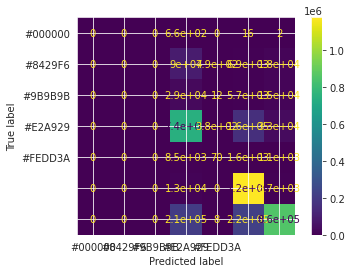

In [34]:
scores_train = clf.score(train[c[0:3]], train[c[-1:]].values.ravel())
scores_test = clf.score(test[c[0:3]], test[c[-1:]].values.ravel())
print('Accuracy train DataSet: {: .1%}'.format(scores_train), 'Accuracy test DataSet: {: .1%}'.format(scores_test))
plot_confusion_matrix(clf, test[c[0:3]], test[c[-1:]].values.ravel())  
plt.show()

As we can see, the accuracy is not bad. The difference between the training and test sets is little. It means that the model is not bad, and for increasing the accuracy we should increase our DataSet. we can test by adding all the directories with images.

In [35]:
test_image = 5 # choose the number of images from the data list
mask_test = data[test_image:test_image+1] # Test Image + Mask
mask_test_DataSet = create_DataSet(mask_test) #Build a DataSet
print(mask_test_DataSet)

       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0         142      135     151    132       41     246  #8429F6
1         134      127     143    132       41     246  #8429F6
2         102       96     110    132       41     246  #8429F6
3         117      111     125    132       41     246  #8429F6
4         125      119     131    132       41     246  #8429F6
...       ...      ...     ...    ...      ...     ...      ...
719837      9        7      10    226      169      41  #E2A929
719838     12       10      13    226      169      41  #E2A929
719839      8        6       9    226      169      41  #E2A929
719840      8        6       9    226      169      41  #E2A929
719841      8        6       9    226      169      41  #E2A929

[719842 rows x 7 columns]


In [ ]:
-> Then, calculate the hex colour of classes using our model:

In [36]:
c = mask_test_DataSet.columns
mask_test_predict = clf.predict(mask_test_DataSet[c[0:3]])
print(mask_test_predict)

['#8429F6' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']


-> Further, we need to transform the 1D array of colors into a 2D matrix of Hex color using numpy.reshape().

In [37]:
size = mask_test[0][1].size #get original image size
print(size)
predict_img = np.array(mask_test_predict).reshape((size[1], size[0])) #reshaping array of HEX colour
print(predict_img)

(859, 838)
[['#8429F6' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ['#8429F6' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ['#8429F6' '#8429F6' '#8429F6' ... '#E2A929' '#E2A929' '#E2A929']
 ...
 ['#8429F6' '#8429F6' '#8429F6' ... '#E2A929' '#E2A929' '#E2A929']
 ['#8429F6' '#E2A929' '#E2A929' ... '#E2A929' '#E2A929' '#E2A929']
 ['#8429F6' '#E2A929' '#E2A929' ... '#E2A929' '#E2A929' '#E2A929']]


-> Than we create a 3D image matrix with an RGB colour map using colormap.hex2rgb().

In [38]:
rgb_size = np.array(mask_test[0][0]).shape
print("Image size: ", rgb_size)
predict_img_rgb = np.zeros(rgb_size)
for i, r in enumerate(predict_img):
    for j, c in enumerate(r):
        predict_img_rgb[i, j, 0], predict_img_rgb[i, j, 1], predict_img_rgb[i, j, 2] = hex2rgb(c)

Image size:  (838, 859, 3)


-> Let's compare our mask with the original one.

Model mask


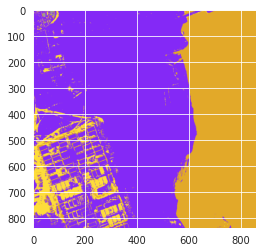

Real mask


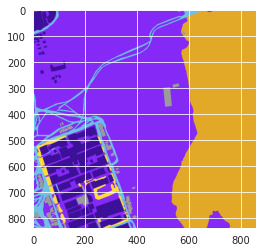

In [39]:
predict_img_rgb = predict_img_rgb.astype('int')
print("Model mask")
plt.imshow(predict_img_rgb)
plt.show()
print("Real mask")
plt.imshow(mask_test[0][1])
plt.show()

We can see that these masks are very similar and we just have to increase the DataSets to improve the accuracy.